In [22]:
!pip install sklearn --upgrade
!pip install numpy --upgrade
!pip install pandas --upgrade
!pip install matplotlib --upgrade

Requirement already up-to-date: sklearn in /anaconda3/lib/python3.6/site-packages (0.0)
Requirement already up-to-date: numpy in /anaconda3/lib/python3.6/site-packages (1.15.4)
Requirement already up-to-date: pandas in /anaconda3/lib/python3.6/site-packages (0.23.4)
Requirement already up-to-date: matplotlib in /anaconda3/lib/python3.6/site-packages (3.0.2)


# Restaurants Clustering

In this section, we apply K-Means unsupervised learning algorithm on the restaurant locations in order to classify the restaurants into clusters.

## Step 1: Import the restaurants location information

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

In [24]:
#Import restaurants dataset
with open('data/yelp_lv_food.json','r') as json_data:
    data = json_data.read()
restaurants_org = json.loads(data)  

In [25]:
#Get the location of restaurants in Las Vegas
restaurants = []
restaurants_locations = list()
for i in range(len(restaurants_org)):
    latitude = restaurants_org[i]['latitude']
    longitude = restaurants_org[i]['longitude']
    if (latitude!=None) and (longitude!=None):
        restaurants.append(restaurants_org[i])
        restaurants_locations.append([latitude,longitude])
restaurants_locations = np.array(restaurants_locations)

## Step 2: Determine how many clusters should restaurants be classified into

In this section, we use the elbow method to determine the optimal numbers of clusters should be classified into. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 30 in the examples), and for each value of k calculate the sum of squared errors (SSE). 

Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In [26]:
#Calcus the SSEs of each value of k (from 1 to 30 in the example)
def cluster_k(restaurants_locations):
    SSE = []  # The MSE of each
    for k in range(1,30):
        estimator = KMeans(n_clusters=k)  # 构造聚类器
        estimator.fit(restaurants_locations)
        SSE.append(estimator.inertia_)
    return SSE
SSE=cluster_k(restaurants_locations)

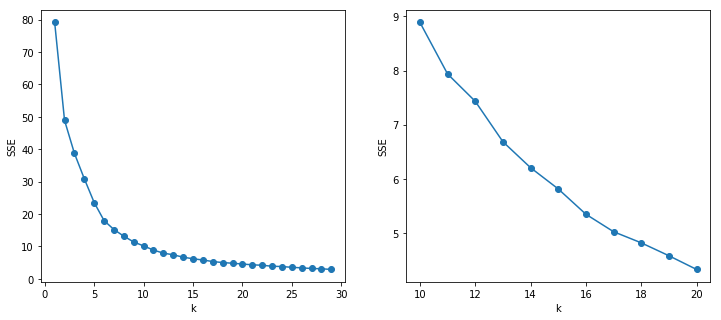

In [27]:
#Visualize 
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1,2,1)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(range(1,30),SSE,'o-')

ax2 = plt.subplot(1,2,2)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(range(10,21),SSE[10:21],'o-')

plt.show()

<h4>From the plots above, k=13 is approximately an 'elbow point'. Therefore, we choose to classified the restaurants into 13 clusters.

## Step 3: Classified the restaurants into 13 clusters, output the clusters dictionary and locations of clusters centers.

In [28]:
def cluster(restaurants, restaurants_locations, k):
    #Fit kmeans model for all the restaurants in Las Vegas
    kmeans = KMeans(n_clusters=k, random_state=0).fit(restaurants_locations)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    
    #Show the restaurant belongs to which cluster
    i = 0
    for restaurant in restaurants:
        restaurant['label'] = int(labels[i])
        i = i + 1
    
    #Create a empty output list
    clusters = list()
    for i in range(k):
        cluster = list()
        clusters.append(cluster)
        
    #Add restaurant information to the empty output list
    for restaurant in restaurants:
        label = restaurant['label']
        clusters[label].append(restaurant)
    
    #Transfor centers ndarry in to a list
    centers =centers.tolist()
    
    return clusters,centers

clusters, centers = cluster(restaurants,restaurants_locations,13)

In [29]:
with open('data/clusters.json', 'w') as f:
    json.dump(clusters, f)
with open('data/clusters_centers.json', 'w') as f:
    json.dump(centers, f)

## Step 4: Visualize the clusters

In [30]:
#Sample 10% restaurants for clusters visualization
import os
import random

result_list = clusters
result_sample_list = []
for i in range(len(result_list)):
    result_sample = random.sample(result_list[i],int(len(result_list[i])/10))
    result_sample_list.append(result_sample)

In [31]:
#Show the map of 10% sampled points
import folium
m = folium.Map(location=[36.16667,-115.13333],zoom_start=10)
color = ['#990033','#CC3300','#99FFFF','FF99CC','FF6633','#00CC66','FF3366',
         '#FF9933','#669999','#990099','#9933FF','#FF6699','#FF3399']
i=0
for result in result_sample_list:
    col = color[i]
    i += 1
    for restaurant in result:
        lat = restaurant['latitude']
        lon = restaurant['longitude']
        name = restaurant['name']
        folium.CircleMarker(
                location = [lat,lon],
                fill = True,
                popup="%s"%name,
                radius = 5,
                color=col,
                ).add_to(m)
m

In [32]:
#Save the full map to html
import folium
m = folium.Map(location=[36.16667,-115.13333],zoom_start=10)
color = ['#990033','#CC3300','#99FFFF','FF99CC','FF6633','#00CC66','FF3366',
         '#FF9933','#669999','#990099','#9933FF','#FF6699','#FF3399']
i=0
for result in result_list:
    col = color[i]
    i += 1
    for restaurant in result:
        lat = restaurant['latitude']
        lon = restaurant['longitude']
        name = restaurant['name']
        folium.CircleMarker(
                location = [lat,lon],
                fill = True,
                popup="%s"%name,
                radius = 5,
                color=col,
                ).add_to(m)
m.save(os.path.join('img-storage','clusters_map.html'))